# SPAM Detection

### Installations and Imports

In [1]:
%pip install numpy pandas tensorflow matplotlib seaborn nltk scikit-learn wordcloud autokeras

# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import autokeras as ak

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\popsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

tf.config.experimental.list_physical_devices('GPU')
!nvidia-smi


Sun Jul  9 19:38:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.61                 Driver Version: 531.61       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0               28W /  N/A|      0MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load Data and make columns uniform

In [3]:
# Load 'lingSpam'
df_ling = pd.read_csv('data\lingSpam.csv')

# Load 'enronSpamSubset'
df_enron = pd.read_csv('data\enronSpamSubset.csv')

# Load 'completeSpamAssassin' 
df_sa = pd.read_csv('data\completeSpamAssassin.csv')

# check columns in dataframes
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

# remove extra column from enron data
df_enron = df_enron.drop(columns=['Unnamed: 0.1'])


print('Removing exta column...')
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

df_enron.head()


Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Removing exta column...
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')


,Unnamed: 0,Body,Label
0,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,Subject: are you listed in major search engine...,1
2,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,"Subject: "" bidstogo "" is places to go , things...",1


### Combine datasets

In [4]:
df_combined = pd.concat([df_sa, df_enron, df_ling])
df_combined.drop('Unnamed: 0', axis = 1, inplace=True)
df_combined.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


### Check for data imbalance

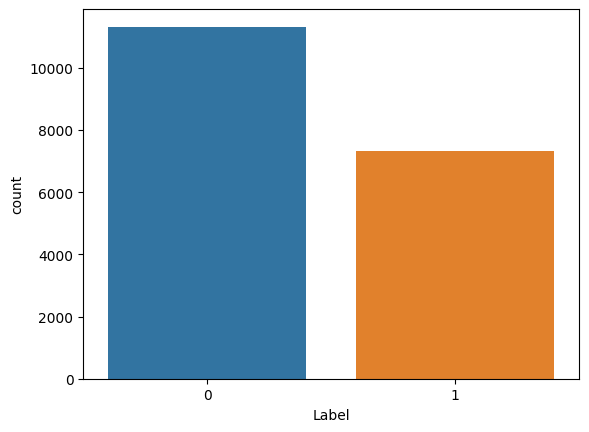

In [5]:
sns.countplot(x='Label', data=df_combined)
plt.show()

Not imbalanced enough to require over or under sampling

### Clean up unneeded words and punctuation

In [6]:
# remove blanks
df_combined = df_combined.dropna()

#  remove the word "Subject" from every email

df_combined['Body'] = df_combined['Body'].str.replace('Subject', '')

# remove punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df_combined['Body']= df_combined['Body'].apply(lambda x: remove_punctuations(x))

# remove "stopwords"
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df_combined['Body'] = df_combined['Body'].apply(lambda text: remove_stopwords(text))
df_combined.head()


# check cleanup results
df_combined.head()


,Body,Label
0,save 70 life insurance spend tolife quote savi...,1
1,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
2,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
3,adult club offers free membership instant acce...,1
4,thought might like 1 slim guaranteed lose 1012...,1


### Make wordclouds

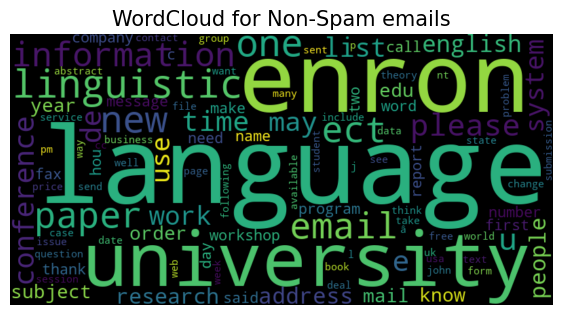

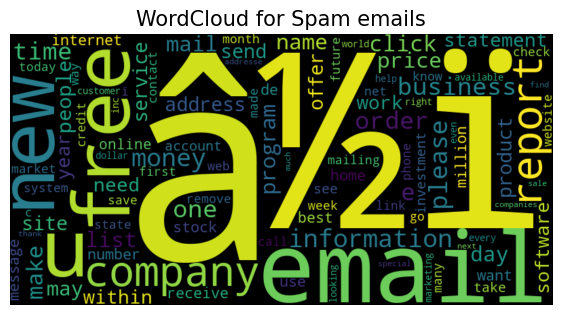

In [7]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['Body'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(df_combined[df_combined['Label'] == 0], typ='Non-Spam')
plot_word_cloud(df_combined[df_combined['Label'] == 1], typ='Spam')


### Split Data

In [8]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(df_combined['Body'].to_numpy(),
													df_combined['Label'].to_numpy(),
													test_size = 0.2,
													random_state = 42)


### Create model

In [12]:
model = ak.TextClassifier(max_trials=30, overwrite = True,seed=42,)

cbs = [tf.keras.callbacks.EarlyStopping(patience=5)]

### Train Model

In [22]:
# Train the model
history = model.fit(X_train, Y_train, callbacks = cbs)



Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
bert              |vanilla           |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate
128               |None              |text_block_1/bert_block_1/max_sequence_length
500               |5000              |text_block_1/max_tokens

Epoch 1/1000
 82/374 [=====>........................] - ETA: 39:48 - loss: 0.7253 - accuracy: 0.5728

### Check accuraccy

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



117/117 [==============================] - 1s 10ms/step - loss: 0.1293 - accuracy: 0.9531
Test Loss : 0.12928539514541626
Test Accuracy : 0.9530830979347229


AttributeError: 'NoneType' object has no attribute 'history'